# **Vader Sentiment Analysis with Word Embeddings - Model Train**

## **1.Sentiment Analysis without Word Embeddings**

#### 1.1. Mouth Drive and Import Environments

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from sklearn.metrics import classification_report
os.chdir('/content/drive/My Drive/Colab Notebooks/') # show our drive directory
! apt-get update -qq > /dev/null   
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! pip install  pyspark==2.4.7 
! pip install nlu > /dev/null    

     |████████████████████████████████| 217.9MB 56kB/s 
     |████████████████████████████████| 204kB 18.9MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.7-py2.py3-none-any.whl size=218279465 sha256=64c884ad2e93bcfadd83859137e03f24a1d5086cc36fa0c3cce9eac5dee9a75a
  Stored in directory: /root/.cache/pip/wheels/34/1f/2e/1e7460f80acf26b08dbb8c53d7ff9e07146f2a68dd5c732be5
Successfully built pyspark


#### 1.2. Import and Edit Dataset 

In [3]:
import nlu
import pandas as pd
train_df= pd.read_csv("csv_files/vader_csv_files/commentsSent01Jan2020.csv",sep=";")
train_df.loc[(train_df.duygu_etiketi == 'pozitif'),'duygu_etiketi']='positive'
train_df.loc[(train_df.duygu_etiketi == 'negatif'),'duygu_etiketi']='negative'
train_df.loc[(train_df.duygu_etiketi == 'notr'),'duygu_etiketi']='neutral'
train_df.sample(5)

,category,date,clean_text,time_period,id,author,created_utc,link_id,parent_id,is_self,subreddit,subreddit_id,score,duygu_skoru,duygu_etiketi
25826,vaccine,14/01/2020,high,"('01/01/2020', '01/02/2020')",feeb9dc,EnoughNoLibsSpam,1579030201,t3_eoob5r,t1_fedysop,NaN,DebateVaccines,t5_3jwf7,1,0.0000,neutral
7812,vaccine,14/01/2020,i had shingles at what the fuck,"('01/01/2020', '01/02/2020')",feczbkp,ambivalentways,1578990941,t3_eo49xh,t1_fe9ptvc,NaN,vaxxhappened,t5_3p3pv,1,-0.5423,negative
23953,vaccine,07/01/2020,do you know what coercion is think for a secon...,"('01/01/2020', '01/02/2020')",fdfq1k8,xNovaz,1578367465,t3_el4lo1,t1_fdfptlb,NaN,DebateVaccines,t5_3jwf7,2,0.0000,neutral
18971,vaccine,29/01/2020,karen your clever use of emojis doesnt validat...,"('01/01/2020', '01/02/2020')",ffxpdxd,socialanxiousavocado,1580329789,t3_evmsjw,t3_evmsjw,NaN,vaxxhappened,t5_3p3pv,1,0.2240,positive
13858,vaccine,22/01/2020,shes basically saying that she doesnt eant her...,"('01/01/2020', '01/02/2020')",ff8pt9v,ImAKamenRider,1579690880,t3_erz0bc,t3_erz0bc,NaN,vaxxhappened,t5_3p3pv,1,0.0000,neutral


#### 1.3. Calculate Sentiment Rate

negative    12390
positive    11770
neutral      7235
Name: duygu_etiketi, dtype: int64


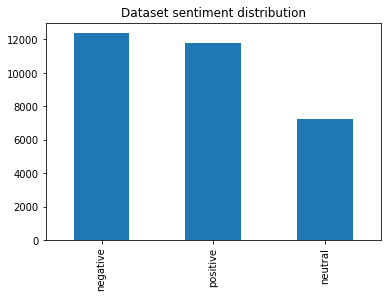

In [4]:
print(train_df.duygu_etiketi.value_counts())
train_df.duygu_etiketi.value_counts().plot.bar(title='Dataset sentiment distribution')

In [5]:
comments_counts=train_df.groupby(['duygu_etiketi']).size().reset_index(name='comment_count')
comments_counts

,duygu_etiketi,comment_count
0,negative,12390
1,neutral,7235
2,positive,11770


In [6]:
comments_counts['comment_percentage'] = comments_counts['comment_count'].apply(lambda x: round(x / train_df.shape[0],2) * 100)
comments_counts

,duygu_etiketi,comment_count,comment_percentage
0,negative,12390,39.0
1,neutral,7235,23.0
2,positive,11770,37.0


## 2.Sentiment Analysis with Word Embeddings


#### 2.1. Edit Data

In [7]:
train_df["text"]=train_df["clean_text"].astype("str")
train_df["y"]=train_df["duygu_etiketi"].astype("str")
columns=['text','y']
train_df = train_df[columns]
train_df.sample(5)

,text,y
10743,i had to submit proof of immunization to take ...,neutral
24062,i agree in which case it will switch from lyin...,negative
14495,the vaccines turn you artistic instead now whi...,neutral
2255,i love how they just start saying chemicals ba...,positive
24103,this reporter got reports of threats in the ha...,negative


#### 2.2. Train Data with classifier

In [8]:
trainable_pipe = nlu.load('train.classifier')
fitted_pipe = trainable_pipe.fit(train_df)
preds = fitted_pipe.predict(train_df,output_level='document')
preds.dropna(inplace=True)
print(classification_report(preds['y'], preds['category']))
preds

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
              precision    recall  f1-score   support

    negative       0.70      0.71      0.71     12390
     neutral       0.72      0.72      0.72      7235
    positive       0.69      0.68      0.68     11770

    accuracy                           0.70     31395
   macro avg       0.70      0.70      0.70     31395
weighted avg       0.70      0.70      0.70     31395



,default_name_embeddings,y,category_confidence,text,category,document
origin_index,,,,,,
0,"[0.017450980842113495, 0.08058405667543411, -0...",negative,0.875138,hurts less to put the needle in quickly not su...,negative,hurts less to put the needle in quickly not su...
1,"[-0.014144825749099255, 0.020167605951428413, ...",neutral,0.976335,tb test,neutral,tb test
2,"[0.023443184792995453, -0.05832136794924736, -...",neutral,0.995345,my body my choice,neutral,my body my choice
3,"[0.006487067323178053, 0.06978738307952881, 0....",positive,0.825309,they say if you have auto immune your child ha...,positive,they say if you have auto immune your child ha...
4,"[0.007191074546426535, 0.03851733356714249, -0...",positive,0.997757,i think the future would be lower adjuvant vac...,positive,i think the future would be lower adjuvant vac...
...,...,...,...,...,...,...
31390,"[0.035669051110744476, -0.008577534928917885, ...",neutral,0.996136,now that didnt took long for them to jump on t...,neutral,now that didnt took long for them to jump on t...
31391,"[-0.061275895684957504, 0.06904545426368713, -...",positive,0.754268,i simply showed them civilly the graphs of eac...,positive,i simply showed them civilly the graphs of eac...
31392,"[0.0008234876440837979, -0.04947131872177124, ...",neutral,0.863870,ive changed quite a few mostly online but rece...,neutral,ive changed quite a few mostly online but rece...


In [9]:
# train longer
trainable_pipe['classifier_dl'].setMaxEpochs(70)  
fitted_pipe = trainable_pipe.fit(train_df)
preds = fitted_pipe.predict(train_df,output_level='document')
preds.dropna(inplace=True)
print(classification_report(preds['y'], preds['category']))
preds

              precision    recall  f1-score   support

    negative       0.81      0.85      0.83     12390
     neutral       0.84      0.81      0.82      7235
    positive       0.81      0.78      0.80     11770

    accuracy                           0.82     31395
   macro avg       0.82      0.81      0.82     31395
weighted avg       0.82      0.82      0.82     31395



,default_name_embeddings,y,category_confidence,text,category,document
origin_index,,,,,,
0,"[0.017450980842113495, 0.08058405667543411, -0...",negative,0.999542,hurts less to put the needle in quickly not su...,negative,hurts less to put the needle in quickly not su...
1,"[-0.014144825749099255, 0.020167605951428413, ...",neutral,1.000000,tb test,neutral,tb test
2,"[0.023443184792995453, -0.05832136794924736, -...",neutral,0.999990,my body my choice,neutral,my body my choice
3,"[0.006487067323178053, 0.06978738307952881, 0....",positive,0.999949,they say if you have auto immune your child ha...,positive,they say if you have auto immune your child ha...
4,"[0.007191074546426535, 0.03851733356714249, -0...",positive,0.999775,i think the future would be lower adjuvant vac...,positive,i think the future would be lower adjuvant vac...
...,...,...,...,...,...,...
31390,"[0.035669051110744476, -0.008577534928917885, ...",neutral,1.000000,now that didnt took long for them to jump on t...,neutral,now that didnt took long for them to jump on t...
31391,"[-0.061275895684957504, 0.06904545426368713, -...",positive,0.994780,i simply showed them civilly the graphs of eac...,positive,i simply showed them civilly the graphs of eac...
31392,"[0.0008234876440837979, -0.04947131872177124, ...",neutral,1.000000,ive changed quite a few mostly online but rece...,neutral,ive changed quite a few mostly online but rece...


In [10]:
stored_model_path = './models/vader_trained' 
fitted_pipe.save(stored_model_path)

Stored model in ./models/vader_trained


#### 2.3. Calculate Sentiment Rate


negative    13076
positive    11369
neutral      6950
Name: category, dtype: int64


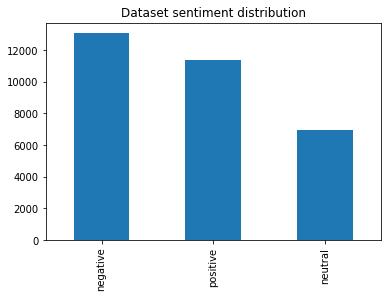

In [11]:
print(preds.category.value_counts())
preds.category.value_counts().plot.bar(title='Dataset sentiment distribution')

In [12]:
comments_counts_train=preds.groupby(['category']).size().reset_index(name='comment_count')
comments_counts_train

,category,comment_count
0,negative,13076
1,neutral,6950
2,positive,11369


In [13]:
comments_counts_train['comment_percentage'] = comments_counts_train['comment_count'].apply(lambda x: round(x / preds.shape[0],2) * 100)
comments_counts_train

,category,comment_count,comment_percentage
0,negative,13076,42.0
1,neutral,6950,22.0
2,positive,11369,36.0


#### 2.4. Save Dataset 

In [14]:
train_df= pd.read_csv("csv_files/vader_csv_files/commentsSent01Jan2020.csv",sep=";")
df=pd.DataFrame()
df[["id","date"]]=train_df[["id","date"]]
df[["text","category"]]=preds[["text","category"]]
df.to_csv("csv_files/vader_train_csv_files/commentsSentTrain01Jan2020.csv")